In [538]:
import sklearn
import rasterio as rio
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [8]:
path = '/home/jose/Downloads/partitions.npy'

with open(path,'rb') as f:
    npfile = np.load(f)
      
      
    data = npfile

In [10]:
data.shape

(160000, 18, 86)

In [13]:
### Loading in the satelite image

#variabels
  
xdim = 400    # cropped out E - W direction 
ydim = 400    # cropped out N - S direction
wv3dim = 16   # band or spectral resolution 

band = {
          1 : 'Coastal', 
          2 : 'Blue',
          3 : 'Green',
          4 : 'Yellow',
          5 : 'Red',
          6 : 'RedEdge',
          7 : 'NIR1',
          8 : 'NIR2',
          9 : 'SWIR-1',
          10: 'SWIR-2',
          11: 'SWIR-3',
          12: 'SWIR-4',
          13: 'SWIR-5',
          14: 'SWIR-6',
          15: 'SWIR-7',
          16: 'SWIR-8'

          }


# train test split
train = 0.2
test =  0.8
  
# loading in image
wv3_path = '/home/jose/Downloads/fixed_field_area.tif'
#creates a rasterio object 
raster = rio.open(wv3_path, mode='r')

# the raw numpy array without processing
array = raster.read()[:,0:xdim,0:ydim]


In [19]:
### Loading in the mine locations or the LABELS

mineloc_path = '/home/jose/Downloads/mine_locations_raster_1x1m.tif'

labels = rio.open(mineloc_path, mode='r')

labels_array = labels.read()


In [28]:
def flat_arr(arr):
    
    array = arr
    
    # if it is multispectral image
    if array.shape[0] == wv3dim:
  
    # creates a numpy array that will be correctly processed
        flat = array
      
      # this is the flattened array 
        flat = np.moveaxis(flat, 0, -1)
        flat = flat.reshape(160000,16)
      
    # if it is the target or variate (answers)  
    else:
      
        flat = array
      
      # this is the flattened array 
        flat = np.moveaxis(flat, 0, -1)
        flat = flat.reshape(160000,1)
    
    
    
    return flat



flat_label = flat_arr(labels_array)


ValueError: cannot reshape array of size 186140 into shape (160000,1)

In [138]:
# loading in training data + labels
trainX = pd.read_csv('/home/jose/Train_X.csv',index_col = 0, header = 0)
train_y = pd.read_csv('/home/jose/Train_y.csv',index_col = 0, header = 0)


In [140]:
# loading in test data
testX = pd.read_csv('/home/jose/TestX.csv',index_col = 0, header = 0)
test_y = pd.read_csv('/home/jose/Test_y.csv',index_col = 0, header = 0)


,0
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
...,...
729,0.0
730,0.0
731,0.0
732,0.0


In [152]:
butt = np.asarray(train_y)
train_y = np.reshape(butt, [2931,]) # *** TRAIN_y

from sklearn.svm import SVC, LinearSVC

In [617]:
from sklearn.svm import SVC, LinearSVC
svc = SVC(C=100000.0, gamma=1e-07, random_state=0, kernel='rbf', probability=True).fit(trainX, train_y)
score_svc = svc.score(testX, test_y)
predict_svc = svc.predict(testX)

In [618]:
score_svc

0.9087193460490464

In [181]:
# Image raster stuff
wv3_path = '/home/jose/Downloads/fixed_field_area.tif'

raster = rio.open(wv3_path)
array = raster.read()[:,0:xdim,0:ydim]
array.shape

In [188]:
# Image raster flat to fit models!!! ******** USE FLAT FOR ALL
flat = np.moveaxis(array, 0, -1)
flat = flat.reshape(160000,16)

(16, 400, 400)

<AxesSubplot:>

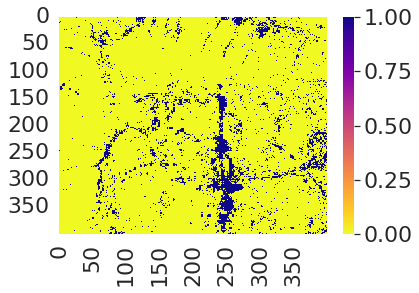

In [727]:
# Support Vector machine predictions and log confidence
predict_raster_svc = svc.predict(flat)
#sns.heatmap(decision_prob.reshape([400,400]),cmap='plasma_r')


decision_prob_svc = svc.decision_function(flat)
log_prob_svc = svc.predict_proba(flat)
sns.heatmap(decision_prob_svc.reshape([400,400]),cmap='plasma_r',xticklabels=50,yticklabels=50)

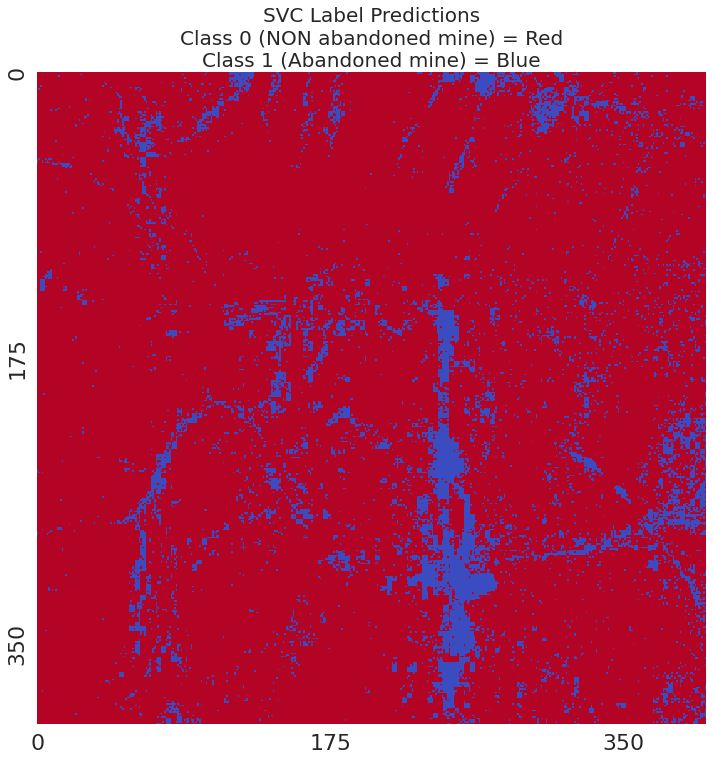

In [753]:
# label map
plt.figure(figsize = (12,12))
sns.heatmap(predict_raster_svc .reshape([400,400]),cmap='coolwarm_r',xticklabels=175,yticklabels=175,cbar=False)
plt.title('SVC Label Predictions\nClass 0 (NON abandoned mine) = Red\nClass 1 (Abandoned mine) = Blue',fontsize=20)
#plt.savefig('label_predict_SVC_TM',dpi=500)

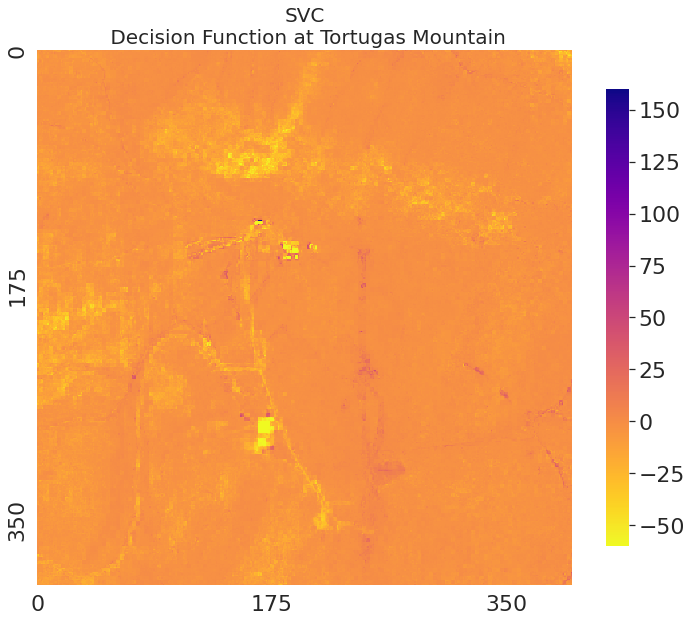

In [702]:
# Decision Function
plt.figure(figsize = (12,12))
sns.heatmap(decision_prob_svc.reshape([400,400]),cmap='plasma_r',square=True,xticklabels=175,yticklabels=175,cbar_kws={"shrink": 0.7},vmin=-60,vmax=160)
plt.title('SVC\n Decision Function at Tortugas Mountain',fontsize=20)
plt.savefig('dec_func_SVC_TM',dpi=500)

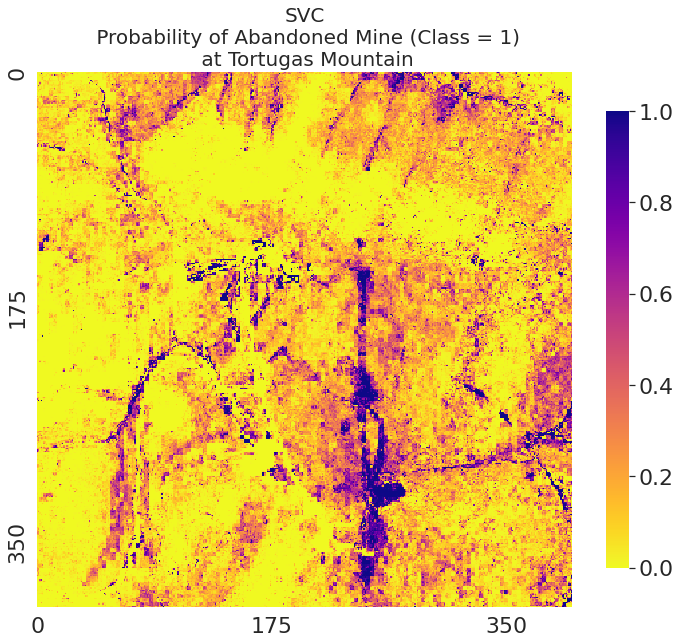

In [693]:
# log proboability class 0
prob_0_svc = log_prob_svc[:,1]
sns.set(font_scale=2)
plt.figure(figsize = (12,12))
sns.heatmap(prob_0_svc.reshape([400,400]),cmap='plasma_r',xticklabels=175,yticklabels=175,square=True,cbar_kws={"shrink": 0.7},vmin=0.0,vmax=1.0)

plt.title('SVC\n Probability of Abandoned Mine (Class = 1)\n at Tortugas Mountain',fontsize=20)
plt.savefig('SVC_TM_prob_1',dpi=500)

#log_prob_svc.shape


In [519]:
# getting hyperparameter tuning

C_range = np.linspace(1e-2, 100000, 20)
gamma_range = np.linspace(1e-09, 1e-04, 20)
param_grid = dict(C=C_range, gamma=gamma_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
grid.fit(trainX, train_y)

print("The best parameters are with a score of", (grid.best_params_, grid.best_score_))


The best parameters are with a score of ({'C': 5263.167368421053, 'gamma': 1.0527210526315791e-05}, 0.8841567291311755)


<AxesSubplot:>

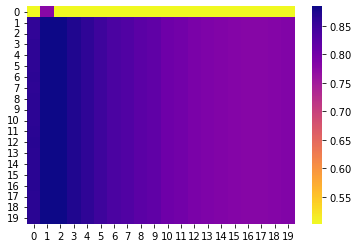

In [520]:
#The best parameters are with a score of ({'C': 14736.842105263157, 'gamma': 1e-07}, 0.91618398637138)

scores_svc = grid.cv_results_["mean_test_score"].reshape(len(C_range), len(gamma_range))
sns.heatmap(scores_svc,cmap='plasma_r')

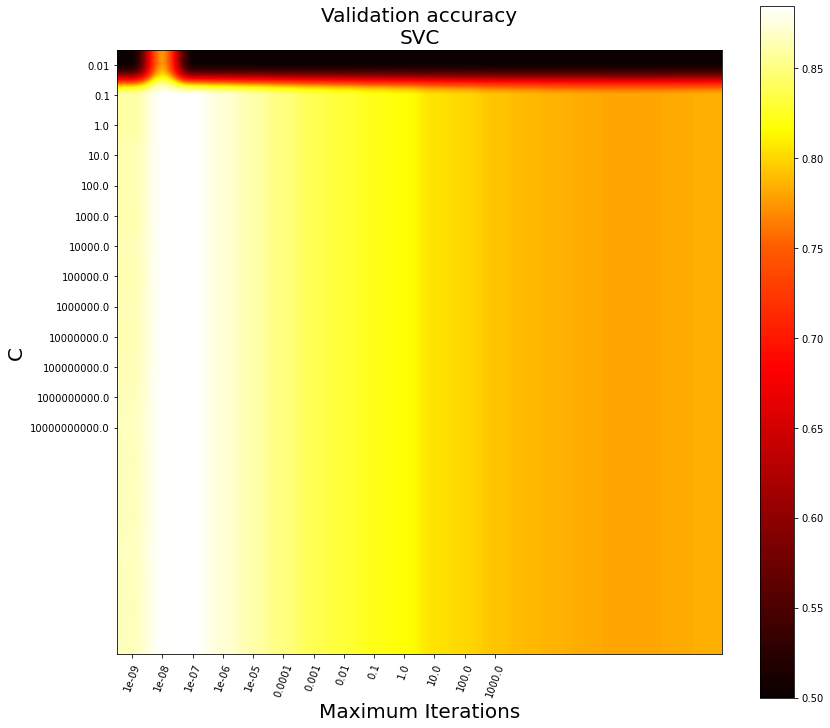

In [575]:
plt.figure(figsize=(14, 12))
plt.subplots_adjust(left=0.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(
    scores_svc,
    interpolation="kaiser",
    cmap=plt.cm.hot,
    norm=MidpointNormalize(vmin=0.5, midpoint=0.75),
)
plt.xlabel("Maximum Iterations",fontsize=20)
plt.ylabel("C",fontsize=20)
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=70)
plt.yticks(np.arange(len(C_range)), C_range)
plt.title("Validation accuracy\nSVC",fontsize=20)
#plt.savefig('log_cv',dpi=500)
plt.show()

# Logistic Regression

In [211]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

In [350]:
# getting hyperparameter tuning

C_range = np.linspace(.01, 10, 20)
maxiter_range = np.linspace(1000, 10000, 20)
param_grid = dict(C=C_range, max_iter=maxiter_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(LogisticRegression(), param_grid=param_grid, cv=cv)
grid.fit(trainX, train_y)

print("The best parameters are with a score of", (grid.best_params_, grid.best_score_))


/home/jose/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/jose/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

/home/jose/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/jose/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

The best parameters are with a score of ({'C': 8.42263157894737, 'max_iter': 1000.0}, 0.8412265758091992)


<AxesSubplot:>

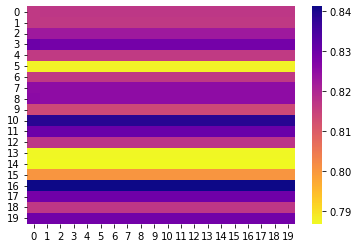

In [352]:
#logr = LogisticRegression(max_iter=1000,C=.1).fit(trainX, train_y)
scores = grid.cv_results_["mean_test_score"].reshape(len(C_range), len(maxiter_range))
sns.heatmap(scores,cmap='plasma_r')

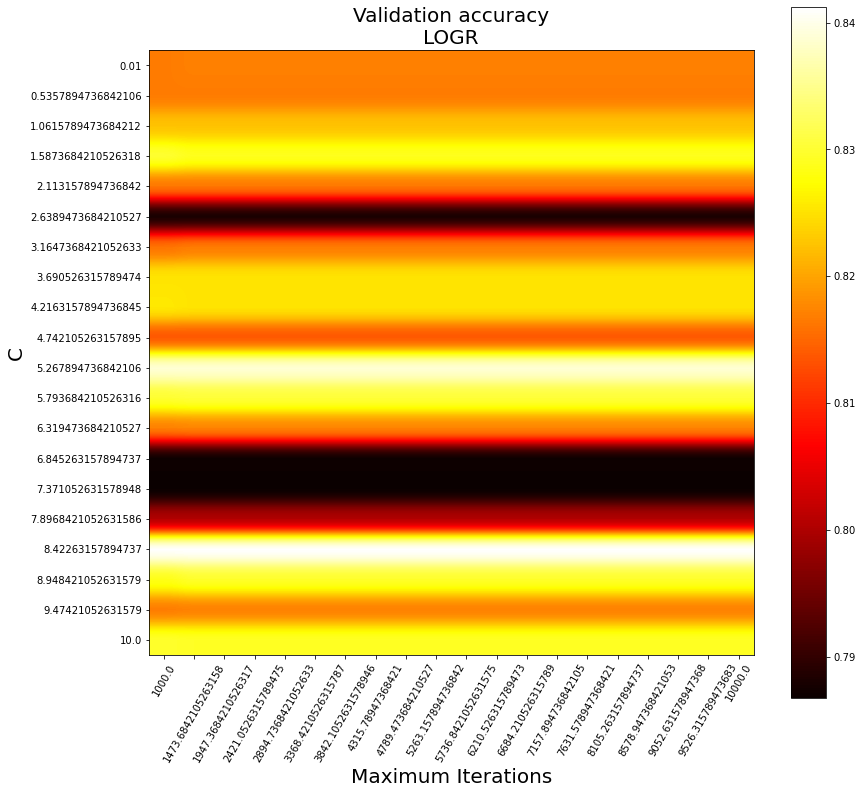

In [353]:
plt.figure(figsize=(14, 12))
plt.subplots_adjust(left=0.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(
    scores,
    interpolation="kaiser",
    cmap=plt.cm.hot,
    #norm=MidpointNormalize(vmin=0.2, midpoint=0.92),
)
plt.xlabel("Maximum Iterations",fontsize=20)
plt.ylabel("C",fontsize=20)
plt.colorbar()
plt.xticks(np.arange(len(maxiter_range)), maxiter_range, rotation=60)
plt.yticks(np.arange(len(C_range)), C_range)
plt.title("Validation accuracy\nLOGR",fontsize=20)
#plt.savefig('log_cv',dpi=500)
plt.show()

In [387]:
# Running model to fit image and produce decision prob
logr = LogisticRegression(C=.1, max_iter=1000).fit(trainX, train_y)

<AxesSubplot:>

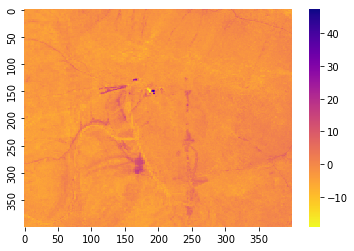

In [399]:
predict_raster_logr = logr.predict(flat)
#sns.heatmap(predict_raster_logr.reshape([400,400]),cmap='RdYlBu')


decision_prob_logr = logr.decision_function(flat)
sns.heatmap(decision_prob_logr.reshape([400,400]),cmap='plasma_r',xticklabels=50,yticklabels=50)

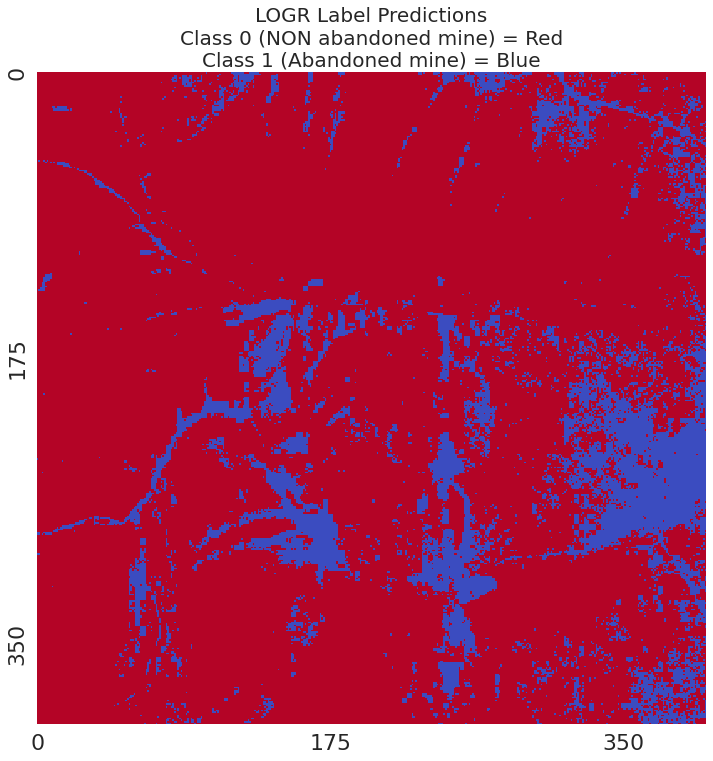

In [755]:
#label map
plt.figure(figsize = (12,12))
sns.heatmap(predict_raster_logr.reshape([400,400]),cmap='coolwarm_r',xticklabels=175,yticklabels=175,cbar=False)
plt.title('LOGR Label Predictions\nClass 0 (NON abandoned mine) = Red\nClass 1 (Abandoned mine) = Blue',fontsize=20)
plt.savefig('label_predict_logr_TM',dpi=500)

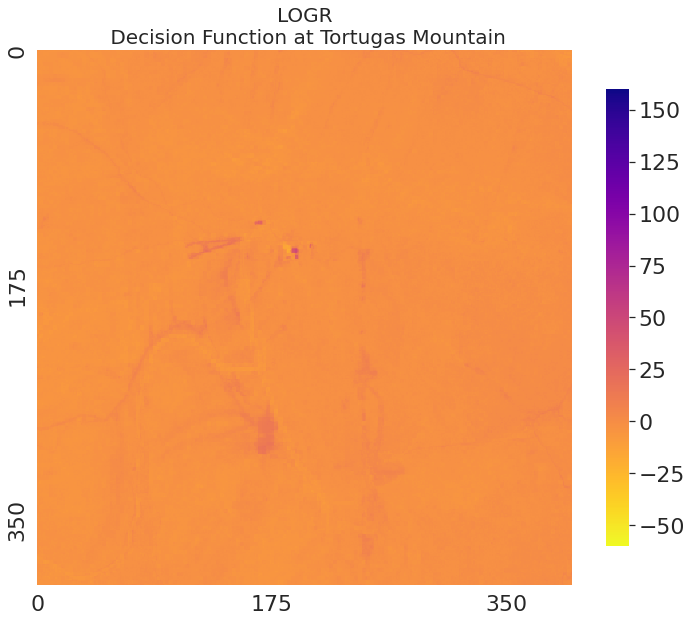

In [769]:
# Decision Function LOGR
plt.figure(figsize = (12,12))
sns.heatmap(decision_prob_logr.reshape([400,400]),cmap='plasma_r',square=True,xticklabels=175,yticklabels=175,cbar_kws={"shrink": 0.7},vmin=-60,vmax=160)
plt.title('LOGR\n Decision Function at Tortugas Mountain',fontsize=20)
plt.savefig('dec_func_logr_TM',dpi=500)

In [761]:
logr_prob = logr.predict_proba(flat)

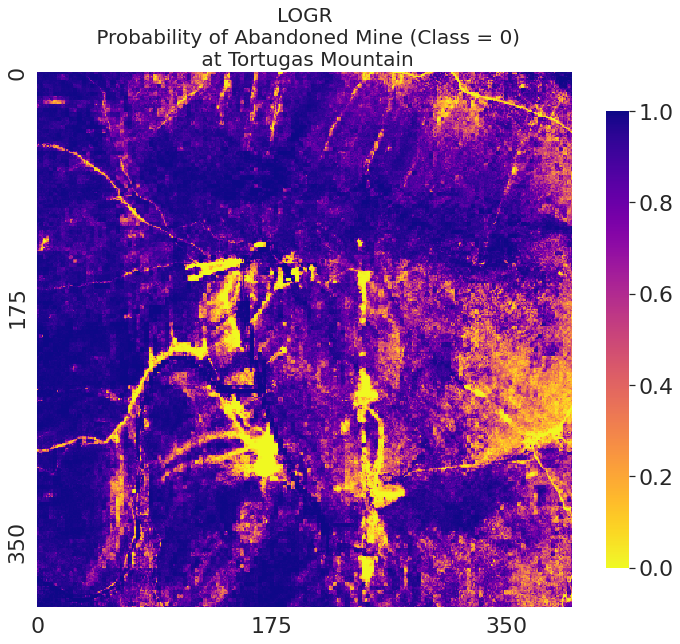

In [766]:
# log proboability class 0
prob_0_logr = logr_prob[:,0]
#sns.set(font_scale=2)
plt.figure(figsize = (12,12))
sns.heatmap(prob_0_logr.reshape([400,400]),cmap='plasma_r',xticklabels=175,yticklabels=175,square=True,cbar_kws={"shrink": 0.7},vmin=0.0,vmax=1.0)

plt.title('LOGR\n Probability of Abandoned Mine (Class = 0)\n at Tortugas Mountain',fontsize=20)
plt.savefig('LOGR_TM_prob_0',dpi=500)

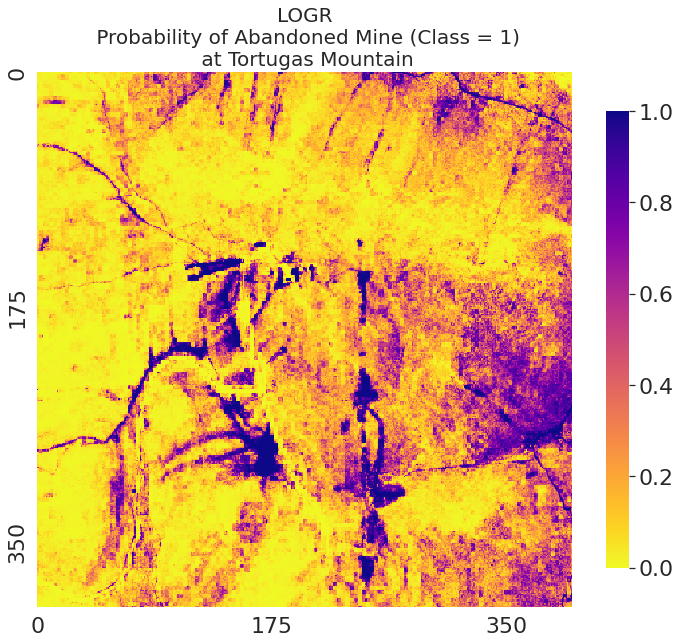

In [767]:
# log proboability class 1
prob_1_logr = logr_prob[:,1]
#sns.set(font_scale=2)
plt.figure(figsize = (12,12))
sns.heatmap(prob_1_logr.reshape([400,400]),cmap='plasma_r',xticklabels=175,yticklabels=175,square=True,cbar_kws={"shrink": 0.7},vmin=0.0,vmax=1.0)

plt.title('LOGR\n Probability of Abandoned Mine (Class = 1)\n at Tortugas Mountain',fontsize=20)
plt.savefig('LOGR_TM_prob_1',dpi=500)

# Linear Regression

In [431]:
from sklearn.linear_model import LinearRegression

linreg = LinearRegression().fit(trainX, train_y)
score = linreg.score(testX, test_y) * 100
predict_raster_linreg = linreg.predict(flat)

Text(0.5, 1.0, 'Linear Regression\nVariate Predictions')

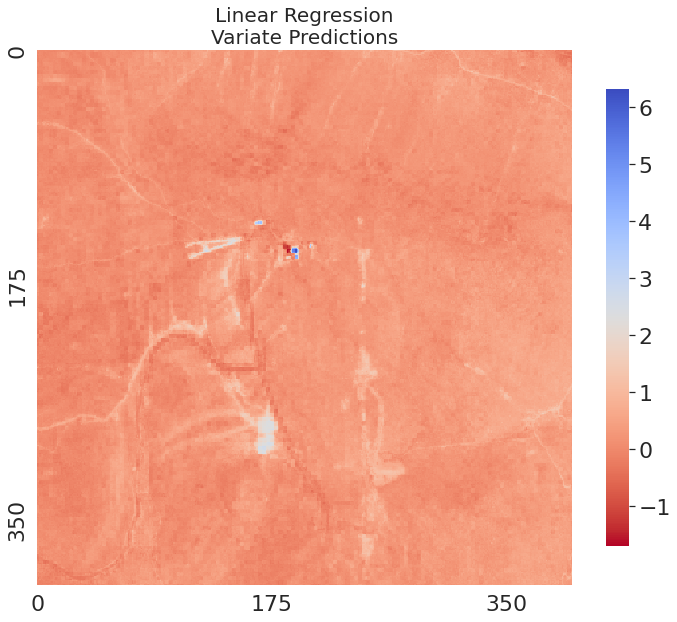

In [1091]:
# predictions variate
#label map
plt.figure(figsize = (12,12))
sns.heatmap(predict_raster_linreg.reshape([400,400]),cmap='coolwarm_r',xticklabels=175,yticklabels=175,cbar_kws={"shrink": 0.7},square=True)
plt.title('Linear Regression\nVariate Predictions',fontsize=20)
#plt.savefig('label_predict_logr_TM',dpi=500)

In [1068]:
# Models based on 86th part
pred_trainX = linreg.predict(trainX)
pred_testX = linreg.predict(testX)

# reshaping to fit train and test dimension
p_train = np.reshape(pred_trainX,[2931,1])
p_test = np.reshape(pred_testX, [734,1])


# new model generated from PCR variates + LOGR
log_linreg = LogisticRegression(C=.001, max_iter=1000).fit(p_train, train_y)

score = log_linreg.score(p_test, test_y) * 100
score

83.65122615803816

In [1069]:
# finding hyperparameters for log post linreg
C_range = np.logspace(-7, 1, 5)
maxiter_range = np.logspace(1, 5, 5)
param_grid = dict(C=C_range, max_iter=maxiter_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(LogisticRegression(), param_grid=param_grid, cv=cv)
grid.fit(p_train, train_y)

print("The best parameters are with a score of", (grid.best_params_, grid.best_score_))


The best parameters are with a score of ({'C': 0.001, 'max_iter': 10.0}, 0.8541737649063033)


/home/jose/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/jose/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

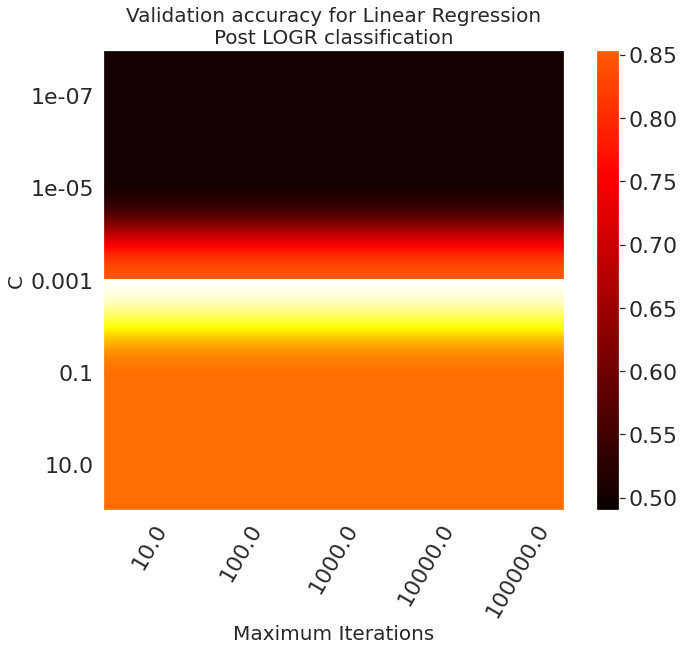

In [1070]:
scores = grid.cv_results_["mean_test_score"].reshape(len(C_range), len(maxiter_range))


plt.figure(figsize=(12, 8))
plt.subplots_adjust(left=0.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(
    scores,
    interpolation="kaiser",
    cmap=plt.cm.hot,
    norm=MidpointNormalize(vmin=0.49, midpoint=0.852),
)
plt.xlabel("Maximum Iterations",fontsize=20)
plt.ylabel("C",fontsize=20)
plt.colorbar()
plt.xticks(np.arange(len(maxiter_range)), maxiter_range, rotation=60)
plt.yticks(np.arange(len(C_range)), C_range)
plt.grid(b=None)

plt.title("Validation accuracy for Linear Regression\nPost LOGR classification",fontsize=20)
plt.savefig('linreglog_cv',dpi=500)
plt.show()

# PCR

In [1071]:
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

In [1072]:
#
pcr = make_pipeline(StandardScaler(), PCA(n_components=2), LinearRegression()).fit(trainX, train_y)
score = pcr.score(testX, test_y) * 100
predicted_raster_pcr = pcr.predict(flat)

In [1075]:
# generating logr classification space based on PCR derived variates
pred_trainX = pcr.predict(trainX)
pred_testX = pcr.predict(testX)

# reshaping to fit train and test dimension
p_train = np.reshape(pred_trainX,[2931,1])
p_test = np.reshape(pred_testX, [734,1])


# new model generated from PCR variates + LOGR
log_pcr = LogisticRegression(C=10, max_iter=1000).fit(p_train, train_y)

score = log_pcr.score(p_test, test_y) * 100
score


79.01907356948229

In [1078]:
# finding hyperparameters for log post linreg
C_range = np.logspace(-7, 1, 5)
maxiter_range = np.logspace(1, 5, 5)
param_grid = dict(C=C_range, max_iter=maxiter_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(LogisticRegression(), param_grid=param_grid, cv=cv)
grid.fit(p_train, train_y)

print("The best parameters are with a score of", (grid.best_params_, grid.best_score_))


The best parameters are with a score of ({'C': 0.1, 'max_iter': 10.0}, 0.8003407155025553)


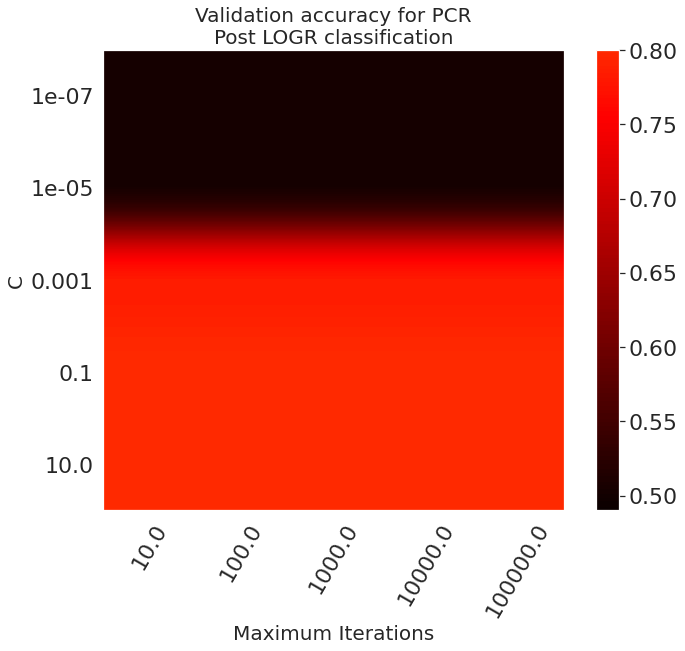

In [1081]:
scores = grid.cv_results_["mean_test_score"].reshape(len(C_range), len(maxiter_range))


plt.figure(figsize=(12, 8))
plt.subplots_adjust(left=0.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(
    scores,
    interpolation="kaiser",
    cmap=plt.cm.hot,
    norm=MidpointNormalize(vmin=0.49, midpoint=0.852),
)
plt.xlabel("Maximum Iterations",fontsize=20)
plt.ylabel("C",fontsize=20)
plt.colorbar()
plt.xticks(np.arange(len(maxiter_range)), maxiter_range, rotation=60)
plt.yticks(np.arange(len(C_range)), C_range)
plt.grid(b=None)

plt.title("Validation accuracy for PCR\nPost LOGR classification",fontsize=20)
plt.savefig('PCRlog_cv',dpi=500)
plt.show()

<AxesSubplot:>

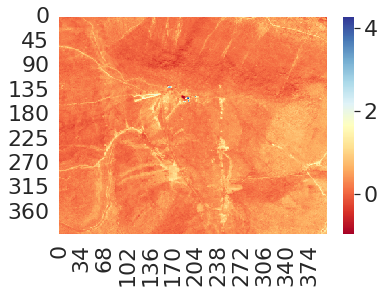

In [1080]:
sns.heatmap(predicted_raster_pcr.reshape([400,400]),cmap='RdYlBu')

# PLSR

In [469]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [1082]:
plsr = PLSRegression(n_components=2).fit(trainX, train_y)
score = plsr.score(testX, test_y) * 100
predict_raster_plsr = plsr.predict(flat)

In [1083]:
# generating logr classification space based on PCR derived variates
pred_trainX = plsr.predict(trainX)
pred_testX = plsr.predict(testX)

# reshaping to fit train and test dimension
p_train = np.reshape(pred_trainX,[2931,1])
p_test = np.reshape(pred_testX, [734,1])


# new model generated from PCR variates + LOGR
log_plsr = LogisticRegression(C=.001, max_iter=1000).fit(p_train, train_y)

score = log_plsr.score(p_test, test_y) * 100
score


80.92643051771117

In [1084]:
# finding hyperparameters for log post linreg
C_range = np.logspace(-7, 1, 5)
maxiter_range = np.logspace(1, 5, 5)
param_grid = dict(C=C_range, max_iter=maxiter_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(LogisticRegression(), param_grid=param_grid, cv=cv)
grid.fit(p_train, train_y)

print("The best parameters are with a score of", (grid.best_params_, grid.best_score_))


The best parameters are with a score of ({'C': 10.0, 'max_iter': 10.0}, 0.8201022146507666)


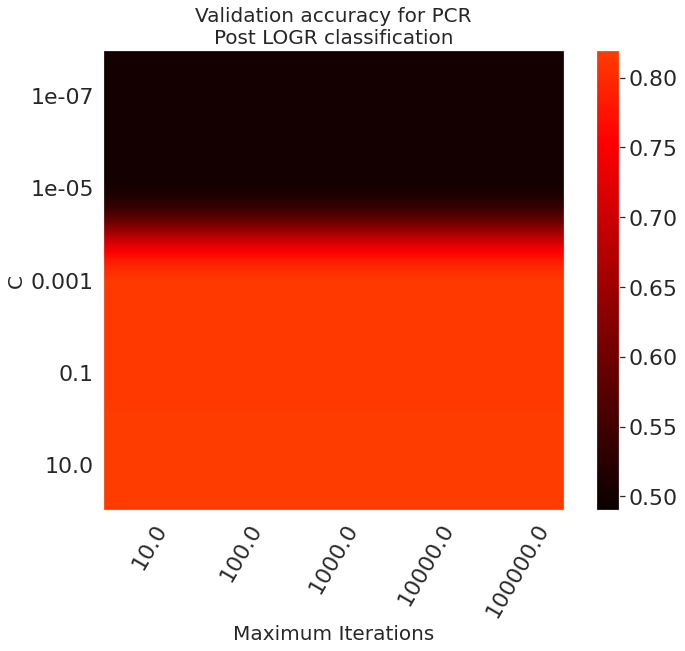

In [1086]:
scores = grid.cv_results_["mean_test_score"].reshape(len(C_range), len(maxiter_range))


plt.figure(figsize=(12, 8))
plt.subplots_adjust(left=0.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(
    scores,
    interpolation="kaiser",
    cmap=plt.cm.hot,
    norm=MidpointNormalize(vmin=0.49, midpoint=0.852),
)
plt.xlabel("Maximum Iterations",fontsize=20)
plt.ylabel("C",fontsize=20)
plt.colorbar()
plt.xticks(np.arange(len(maxiter_range)), maxiter_range, rotation=60)
plt.yticks(np.arange(len(C_range)), C_range)
plt.grid(b=None)

plt.title("Validation accuracy for PCR\nPost LOGR classification",fontsize=20)
plt.savefig('PLSRlog_cv',dpi=500)
plt.show()

In [ ]:
from importlib import reload
plt=reload(plt)